When training a neural network it's easy to overfit to your training dataset. One of the ways to prevent that is using so-call regularization techniques. In this post I will go over some common ways to regularize your network. 



## Default network 
Before we start regularizing I will start with a simple MNIST convolutional network 

In [1]:
import tensorflow as tf
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt

print("The TensorFlow version used in this tutorial is", tf.__version__)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Transform the input into floating point inputs between 0 and 1
x_train = np.expand_dims(x_train.astype('float32') / 255.0, -1)
x_test = np.expand_dims(x_test.astype('float32') / 255.0, -1)

def get_model():
    # Define a very simple model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28,28, 1)),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = get_model()
model.summary()


# Compile and train the model for one epoch... It's only to have something trained, not get the best score
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)
model.fit(x_train, y_train,epochs=1)



The TensorFlow version used in this tutorial is 2.2.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                125450    
Total params: 130,394
Trainable params: 130,394
Non-trainable params: 0
_________________________________________________________________
1875/1875 [==============================] - 33s 17ms/step - loss: 0.1488 - accuracy: 0.9561


## Dropout
One of the simplest ways to regularize your output is by using the so-called dropout technique. With this method random values in the layers of
 your neural network will be set to zero. The underlying idea is that the neural network can't overfit to one specific feature, but instead has to rely on multiple features to be present to recognize your objects. 

Adding dropout is simple, it's a layer available in Keras at `tf.keras.layers.Dropout(dropout_percentage)`. The dropout percentage is something you can set yourself. By default it's set to 0.5. 
Personally I noticed that if you have a hard problem with enough data, and a wide variety of data, dropout should be quite low to be effective. However, if you have a simple problem and not enough data it's better to increase the dropout percentage to make the most of your data. 

In [2]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28,28, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()


# Compile and train the model for one epoch... It's only to have something trained, not get the best score
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)
model.fit(x_train, y_train,epochs=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                125450    
Total params: 130,394
Trainable params: 130,394
Non-trainable params: 0
________________________________________________

In [3]:
model.losses

[]

## Weight decay
When training neural network it's possible for weights to become very large. It's possible to solve a problem that way, but in general this makes the network more vulnerable for weird inputs, as the large multiplications can then stack up giving bad results. It's better for weights to be small to solve the problem, as this tends to generalize better to the whole problem space. 

To prevent weights becoming really big you use so-called weight decay, or weight regularization. The idea is that you give a penalty to the neural network for big weights every training step. This way gradient descent will try to balance out performance with the values of the weights. 

There are two common methods: L1 regularization and L2 regularization. L1 regularization adds a cost proportional to the absolute value of the weights. L2 regularization goes a step further and squares the weights. When you use L1 regularization you punish each weight equally hard when this weight is not zero. With L2 regularization you punish large weights way harder down than small weights. 

I personally like using L2 loss better, as small weigths will hardly be affected, and large weights are punished hard. 

It's not hard to add weight decay to your model. TensorFlows `tf.keras.layers.Conv2D` already has a keyword to add a regularization to your layer. You have to specify the balance of your normal loss and weight decay though. Regularizers that are available in `tf.keras.regularizers` are: 
* L1: If you pass the value of 0.001 you will add `0.001 * abs(weight_value)` to the total loss of your neural network.
* L2: If you pass the value of 0.001 you will add `0.001 * weight_value**2` to the total loss of your neural network.
* L1L2: If you pass the values of 0.002 and 0.001 you will add `0.002 * abs(weight_value) + 0.001 * weight_value**2` to the total loss of your neural network.

Note that for your layers you can add a regularisation for your kernel (your multiplication) and for your bias (the addition after your multiplication). I personally mostly saw a benefit for the multiplication, but it's good to be aware of another variable your can use weight decay on. 

If you are training a neural network it's not important to not only look at the normal loss, but at the two components of the loss. If you don't it's entirely possible that your original goal is not achieved anymore. 

Before showing an example of how you can add the regularisation to your neural network it's interesting to plot the weights we got in the first layer of the previous network (with Dropout). 

(array([ 1.,  0.,  7., 14., 11., 16., 24., 37., 31., 40., 41., 35., 23.,
         5.,  3.]),
 array([-0.40034324, -0.3540591 , -0.30777496, -0.26149082, -0.21520667,
        -0.16892253, -0.12263838, -0.07635424, -0.03007009,  0.01621405,
         0.06249819,  0.10878234,  0.15506648,  0.20135061,  0.24763477,
         0.2939189 ], dtype=float32),
 <a list of 15 Patch objects>)

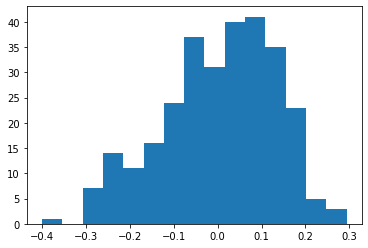

In [4]:
plt.hist(model.layers[0].kernel.numpy().reshape(-1), bins=15)

In [5]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28,28, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()


# Compile and train the model for one epoch... It's only to have something trained, not get the best score
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)
model.fit(x_train, y_train,epochs=1)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                125450    
Total params: 130,394
Trainable params: 130,394
Non-trainable params: 0
_________________________________________________________________
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2390 - accuracy: 0.9495


Now let's plot the weights of the first layer again. As you can see they are a bit smaller due to the regularization we applied on them. 

(array([10.,  7., 11., 25., 29., 69., 30., 26., 18., 27., 13., 15.,  4.,
         1.,  3.]),
 array([-0.12597261, -0.10098308, -0.07599354, -0.051004  , -0.02601446,
        -0.00102493,  0.02396461,  0.04895415,  0.07394368,  0.09893322,
         0.12392276,  0.1489123 ,  0.17390184,  0.19889137,  0.22388092,
         0.24887045], dtype=float32),
 <a list of 15 Patch objects>)

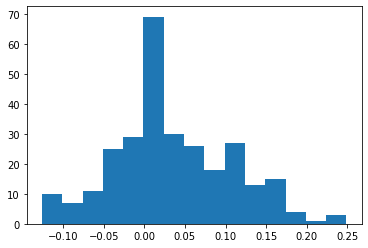

In [6]:
plt.hist(model.layers[0].kernel.numpy().reshape(-1), bins=15)

Another thing which is now present are the losses in the model. You can also see how big they are: 

In [7]:
model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.018498313>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.023712082>]